In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
%store -r data
%store -r target

In [3]:
data = standardize(data)
X_dev, y_dev, X_test, y_test, X_train, y_train, X_val, y_val = split(data,target)

X_train shape: (8091, 51)
X_test shape: (999, 51)
X_val shape: (900, 51)
y_train shape: (8091,)
y_test shape: (999,)
y_val shape: (900,)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [4]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_dev, y_dev)
predsDevdt = model_dt.predict(X_dev)
predsTestdt = model_dt.predict(X_test)

In [5]:
testdt_score =  accuracy_score(y_test, predsTestdt)
devdt_score = accuracy_score(y_dev, predsDevdt)

In [6]:
print("Classification Score for Decision Tree on Dev dataset:\n")
print("Dev Score : ", devdt_score)
print(classification_report(y_dev, predsDevdt))
print("--------------------------------------------------------")
print("Classification Score for Decision Tree on Test dataset:\n")
print("Test Score :", testdt_score)
print(classification_report(y_test, predsTestdt))

Classification Score for Decision Tree on Dev dataset:

Dev Score :  0.9991102213324435
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       904
   classical       1.00      1.00      1.00       894
     country       1.00      1.00      1.00       886
       disco       1.00      1.00      1.00       890
      hiphop       1.00      1.00      1.00       901
        jazz       1.00      1.00      1.00       886
       metal       0.99      1.00      1.00       923
         pop       1.00      1.00      1.00       896
      reggae       1.00      1.00      1.00       904
        rock       1.00      0.99      1.00       907

    accuracy                           1.00      8991
   macro avg       1.00      1.00      1.00      8991
weighted avg       1.00      1.00      1.00      8991

--------------------------------------------------------
Classification Score for Decision Tree on Test dataset:

Test Score : 0.6576576576576577
       

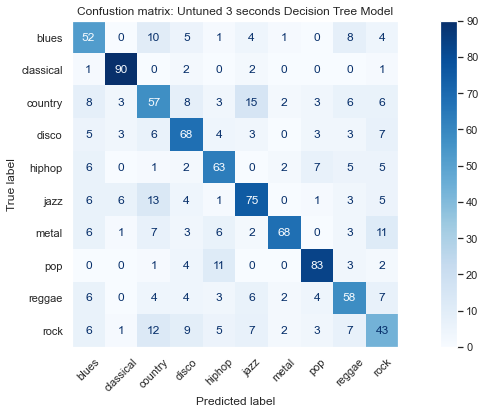

Accuracy : 0.66
Macro F-1 Score : 0.66


In [7]:
# Evaluate Model on Test set
class_labels = list(model_dt.classes_)
macro_f1, accuracy = evaluate_model(predsTestdt, y_test, class_labels, 'Confustion matrix: Untuned 3 seconds Decision Tree Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

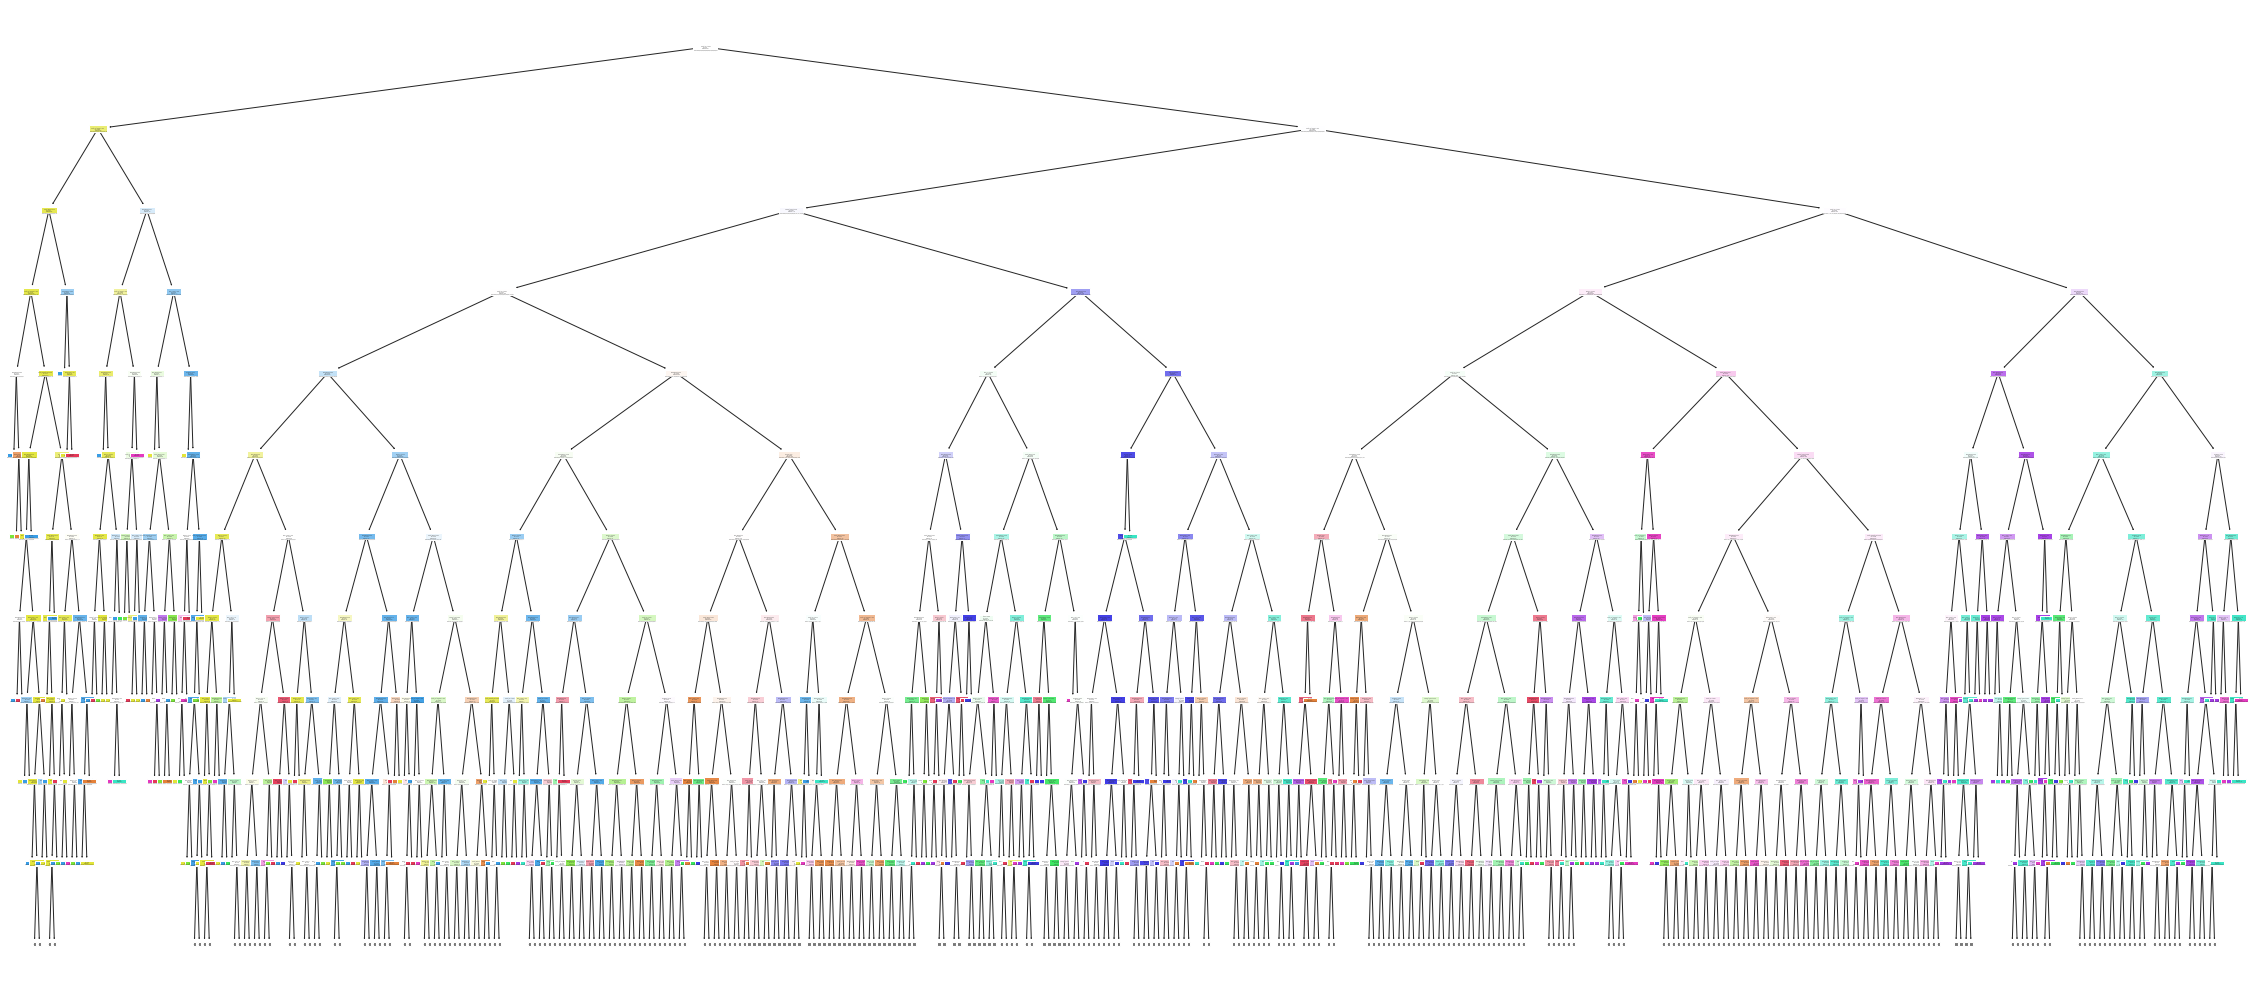

In [8]:
from sklearn import tree 
from sklearn.tree import plot_tree

dev_cols = X_dev.columns.to_list()
fig = plt.figure(figsize=(40,18))
_ = tree.plot_tree(model_dt,max_depth=10,feature_names=dev_cols,filled = True);
plt.savefig('decisiontree_unpruned.png')

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [9]:
print("Max Depth:",model_dt.max_depth)

Max Depth: None


In [10]:
path = model_dt.cost_complexity_pruning_path(X_dev, y_dev)
alphas, impurities = path.ccp_alphas, path.impurities
alphas = alphas[-10:] ###taking last 10 alpha cuz it was taking too much time to train
print(alphas)

[0.00689451 0.00798681 0.00826565 0.01022771 0.01155645 0.01451224
 0.01668139 0.02476492 0.02965249 0.05338311]


In [11]:
model_dt_alpha = []
for i in alphas:
    model_dt1 = DecisionTreeClassifier(random_state=0,ccp_alpha=i)
    model_dt1.fit(X_dev,y_dev)
    model_dt_alpha.append(model_dt1)

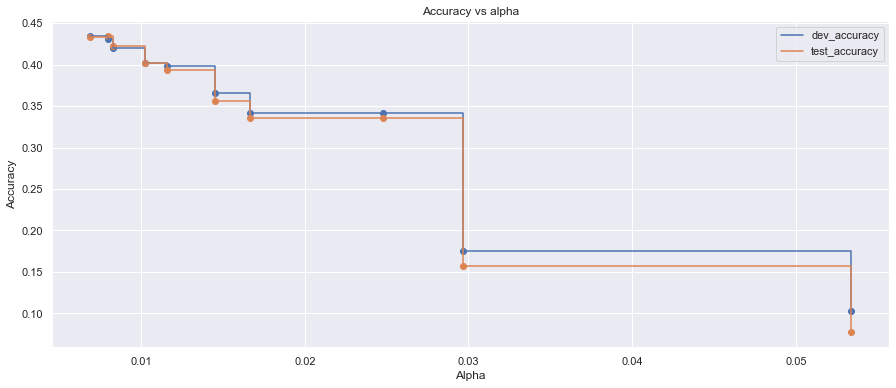

In [12]:
dev_acc = []
test_acc = []
for i in model_dt_alpha:
    y_dev_pred = i.predict(X_dev)
    y_test_pred = i.predict(X_test)
    dev_acc.append(accuracy_score(y_dev, y_dev_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    
plt.scatter(alphas,dev_acc)
plt.scatter(alphas,test_acc)
plt.plot(alphas,dev_acc,label='dev_accuracy',drawstyle="steps-post")
plt.plot(alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs alpha')
plt.show()

In [20]:
###cite : https://www.kaggle.com/arunmohan003/pruning-decision-trees-tutorial

best_alpha_dt = DecisionTreeClassifier(ccp_alpha=0.005)
best_alpha_dt.fit(X_dev,y_dev)
y_pruned_dev = best_alpha_dt.predict(X_dev)
y_pruned_test = best_alpha_dt.predict(X_test)

In [21]:
test_score_pruned =  accuracy_score(y_test, y_pruned_test)
dev_score_pruned = accuracy_score(y_dev, y_pruned_dev)

In [22]:
print("Classification Score for Pruned DT on Dev dataset:\n")
print("Dev Score : ", dev_score_pruned)
print(classification_report(y_dev, y_pruned_dev))
print("--------------------------------------------------------")
print("Classification Score for Pruned DT on Test dataset:\n")
print("Test Score :", test_score_pruned)
print(classification_report(y_test, y_pruned_test))

Classification Score for Pruned DT on Dev dataset:

Dev Score :  0.4583472361250139
              precision    recall  f1-score   support

       blues       0.30      0.55      0.39       904
   classical       0.81      0.82      0.81       894
     country       0.25      0.32      0.28       886
       disco       0.29      0.48      0.36       890
      hiphop       0.57      0.32      0.41       901
        jazz       0.53      0.48      0.50       886
       metal       0.76      0.59      0.67       923
         pop       0.77      0.48      0.59       896
      reggae       0.39      0.55      0.45       904
        rock       0.00      0.00      0.00       907

    accuracy                           0.46      8991
   macro avg       0.47      0.46      0.45      8991
weighted avg       0.47      0.46      0.45      8991

--------------------------------------------------------
Classification Score for Pruned DT on Test dataset:

Test Score : 0.4594594594594595
              p

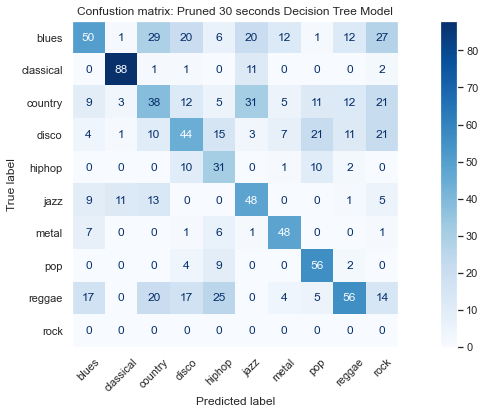

Accuracy : 0.46
Macro F-1 Score : 0.45


In [23]:
# Evaluate Model on Test set
class_labels = list(best_alpha_dt.classes_)
macro_f1, accuracy = evaluate_model(y_pruned_test, y_test, class_labels, 'Confustion matrix: Pruned 30 seconds Decision Tree Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

In [24]:
parameters = {
    'max_depth': np.arange(4, 16, 2, dtype=int),
    'min_samples_leaf': np.linspace(5,100,5,dtype=int),
    'criterion': ["gini", "entropy"]
}

print(parameters)

{'max_depth': array([ 4,  6,  8, 10, 12, 14]), 'min_samples_leaf': array([  5,  28,  52,  76, 100]), 'criterion': ['gini', 'entropy']}


In [25]:
tune_dt = GridSearchCV(estimator = best_alpha_dt, param_grid = parameters, cv = 5)
tune_dt.fit(X_dev, y_dev)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(ccp_alpha=0.005),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 4,  6,  8, 10, 12, 14]),
                         'min_samples_leaf': array([  5,  28,  52,  76, 100])})

In [26]:
print("Best Score :", tune_dt.best_score_)
print("Best Parameters :",tune_dt.best_params_)

Best Score : 0.5811368446566223
Best Parameters : {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 5}


In [27]:
predsDevdt_tuned = tune_dt.predict(X_dev)
predsTestdt_tuned = tune_dt.predict(X_test)

print("Score on Dev data for DT using GridSearchCV:", accuracy_score(y_dev, predsDevdt_tuned))
print("Score on Test data for DT using GridSearchCV:",accuracy_score(y_test, predsTestdt_tuned))

Score on Dev data for DT using GridSearchCV: 0.6340785229674119
Score on Test data for DT using GridSearchCV: 0.5935935935935935


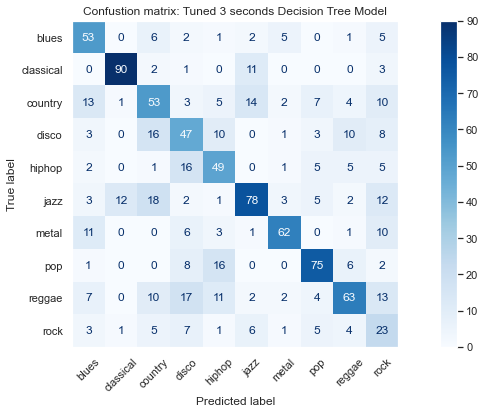

Accuracy : 0.59
Macro F-1 Score : 0.59


In [28]:
# Evaluate Model on Test set
class_labels = list(tune_dt.classes_)
macro_f1, accuracy = evaluate_model(predsTestdt_tuned, y_test, class_labels, 'Confustion matrix: Tuned 3 seconds Decision Tree Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

In [29]:
## Plot top 3 Important Features of tuned model

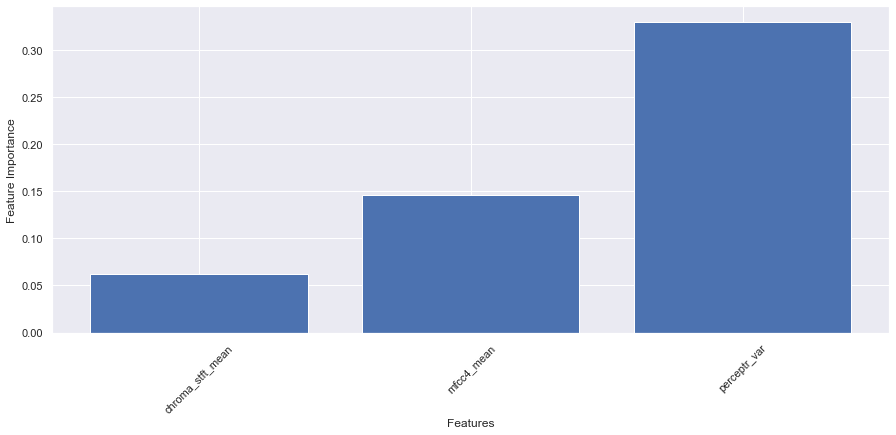

In [30]:
feature_imp_dt = tune_dt.best_estimator_.feature_importances_
final_list_dt = zip(feature_imp_dt,X_dev.columns)
res_dt = sorted(final_list_dt, key = lambda x: x[0])
res_dt = res_dt[-3:]

plt.bar(range(len(res_dt)),[val[0] for val in res_dt],align='center')
plt.xticks(range(len(res_dt)),[val[1] for val in res_dt])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.show()

### Dimensionality reduction of data using PCA

In [31]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.11454404 0.08920634 0.04504717 0.02937379 0.02274578 0.0199205
 0.01584086 0.01368273 0.01132293 0.01090893 0.0089262  0.008148
 0.00722978 0.006841   0.00622566 0.00604702 0.00535509 0.00529876
 0.00508254 0.00483067 0.00471956 0.00416836 0.00364006 0.0034666
 0.00329114 0.0030608  0.00283538 0.00279909 0.00273453 0.00268058]
Sum of Explained Variance: 0.936771733118762


In [32]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,-0.262197,-0.041290,-0.004825,0.077376,-0.092647,-0.202190,0.134131,-0.029626,0.065912,0.012880,...,-0.035492,0.006182,-0.061634,-0.056581,-0.025359,-0.001234,0.000758,0.002734,-0.047533,blues
1,0.911816,0.656705,0.093061,0.041840,0.162399,-0.345907,-0.111052,0.005563,0.107256,0.058347,...,0.020879,-0.118358,0.037518,0.046644,0.028823,-0.094668,0.028246,0.109835,-0.025337,pop
2,-0.346865,0.190015,-0.015068,-0.042262,0.002093,-0.081458,-0.064499,-0.077143,-0.020678,-0.082200,...,-0.024331,0.042039,0.012157,-0.005220,0.057810,-0.008753,-0.024028,-0.005314,-0.030822,rock
3,0.165602,-0.054123,-0.230414,-0.096289,0.254820,0.184294,-0.224988,0.077995,-0.083903,-0.040337,...,0.058228,0.028376,0.054927,0.002094,-0.008795,0.073637,-0.098978,-0.018269,-0.060442,jazz
4,-0.213596,0.153496,0.162250,0.171557,0.164251,-0.038911,0.033231,0.036511,0.089930,0.132917,...,0.094849,0.056333,0.075053,-0.049473,-0.000422,-0.036401,-0.031374,-0.004525,-0.034161,hiphop


### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [33]:
model_pca = model_dt
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTraindt = model_pca.predict(pca_data)
pcaTestdt = model_pca.predict(pca_data_test)

In [34]:
pcatestdt_score =  accuracy_score(y_test, pcaTestdt)
pcadt_score = accuracy_score(y_dev, pcaTraindt)

In [35]:
print("Classification Score for Decision Tree on Train dataset:\n")
print("Train Score : ", pcadt_score)
print("--------------------------------------------------------")
print("Classification Score for Decision Tree on Test dataset:\n")
print("Test Score :", pcatestdt_score)

Classification Score for Decision Tree on Train dataset:

Train Score :  0.9991102213324435
--------------------------------------------------------
Classification Score for Decision Tree on Test dataset:

Test Score : 0.6466466466466466


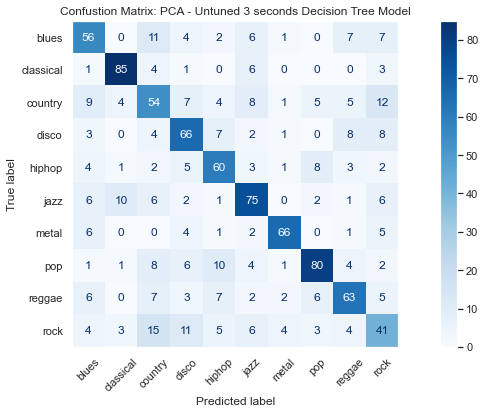

Accuracy : 0.65
Macro F-1 Score : 0.65


In [36]:
# Evaluate Model
class_labels = list(model_pca.classes_)
macro_f1, accuracy = evaluate_model(pcaTestdt, y_test, class_labels, 'Confustion Matrix: PCA - Untuned 3 seconds Decision Tree Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [37]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.262197,-0.041290,-0.004825,0.077376,-0.092647,-0.202190,0.134131,-0.029626,0.065912,0.012880,...,-0.011334,-0.035492,0.006182,-0.061634,-0.056581,-0.025359,-0.001234,0.000758,0.002734,-0.047533
1,0.911816,0.656705,0.093061,0.041840,0.162399,-0.345907,-0.111052,0.005563,0.107256,0.058347,...,0.004598,0.020879,-0.118358,0.037518,0.046644,0.028823,-0.094668,0.028246,0.109835,-0.025337
2,-0.346865,0.190015,-0.015068,-0.042262,0.002093,-0.081458,-0.064499,-0.077143,-0.020678,-0.082200,...,-0.048399,-0.024331,0.042039,0.012157,-0.005220,0.057810,-0.008753,-0.024028,-0.005314,-0.030822
3,0.165602,-0.054123,-0.230414,-0.096289,0.254820,0.184294,-0.224988,0.077995,-0.083903,-0.040337,...,-0.022810,0.058228,0.028376,0.054927,0.002094,-0.008795,0.073637,-0.098978,-0.018269,-0.060442
4,-0.213596,0.153496,0.162250,0.171557,0.164251,-0.038911,0.033231,0.036511,0.089930,0.132917,...,-0.049858,0.094849,0.056333,0.075053,-0.049473,-0.000422,-0.036401,-0.031374,-0.004525,-0.034161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8986,0.223969,0.199646,-0.304657,0.107035,0.128514,-0.077396,0.112852,-0.020109,-0.039323,0.079148,...,-0.060564,0.002981,0.040722,0.021268,0.064093,-0.029224,0.029668,0.048331,0.064055,0.037144
8987,-0.606602,0.172697,-0.153625,0.181308,-0.121463,0.157417,0.025889,0.059115,-0.051084,-0.138440,...,-0.001624,-0.033914,-0.051093,0.007114,-0.005883,-0.021950,-0.003272,-0.065105,-0.020765,0.025270
8988,-0.049191,0.533015,0.390142,-0.164060,0.121949,0.004290,0.132510,-0.029939,0.190410,0.052240,...,0.008438,0.095571,0.100965,-0.006236,0.011923,0.098330,0.034745,-0.108439,-0.063503,0.051203
8989,0.060511,-0.364952,-0.044975,-0.081345,-0.295757,-0.073174,-0.190963,-0.031109,-0.108374,0.086467,...,-0.089248,-0.008000,0.001822,-0.060092,-0.038776,0.154425,0.019984,-0.017461,-0.025943,-0.028437


In [38]:
model_pca_tuned = tune_dt
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTraindt_tuned = model_pca_tuned.predict(pca_data)
pcaTestdt_tuned = model_pca_tuned.predict(pca_data_test)

In [39]:
pcatestdt_score =  accuracy_score(y_test, pcaTestdt_tuned)
pcadt_score = accuracy_score(y_dev, pcaTraindt_tuned)

In [40]:
print("Classification Score for Decision Tree on Train dataset:\n")
print("Train Score : ", pcadt_score)
print("--------------------------------------------------------")
print("Classification Score for Decision Tree on Test dataset:\n")
print("Test Score :", pcatestdt_score)

Classification Score for Decision Tree on Train dataset:

Train Score :  0.5831386942498054
--------------------------------------------------------
Classification Score for Decision Tree on Test dataset:

Test Score : 0.5525525525525525


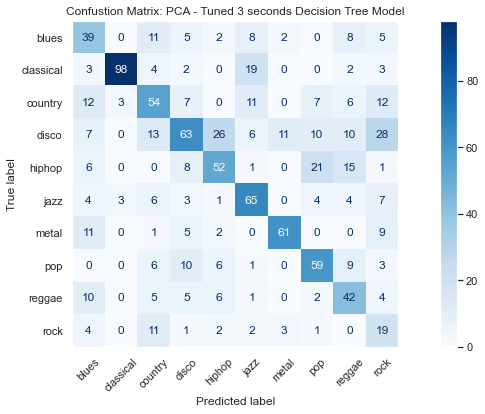

Accuracy : 0.55
Macro F-1 Score : 0.54


In [41]:
# Evaluate Model
class_labels = list(model_dt.classes_)
macro_f1, accuracy = evaluate_model(pcaTestdt_tuned, y_test, class_labels, 'Confustion Matrix: PCA - Tuned 3 seconds Decision Tree Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)